# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [39]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [40]:
# Load in the general demographics data.
azdias = pd.read_csv('./Udacity_AZDIAS_Subset.csv',sep=';')

# Load in the feature summary file.
feature_summ = pd.read_csv('./AZDIAS_Feature_Summary.csv',sep=';', error_bad_lines=False)

In [41]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.shape


(891221, 85)

In [42]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [43]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [44]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [45]:
feature_summ.shape

(85, 4)

In [46]:
feature_summ.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [47]:
feature_summ.tail()

,attribute,information_level,type,missing_or_unknown
80,PLZ8_HHZ,macrocell_plz8,ordinal,[-1]
81,PLZ8_GBZ,macrocell_plz8,ordinal,[-1]
82,ARBEIT,community,ordinal,"[-1,9]"
83,ORTSGR_KLS9,community,ordinal,"[-1,0]"
84,RELAT_AB,community,ordinal,"[-1,9]"


In [48]:
feature_summ.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [49]:
feature_summ.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,SEMIO_DOM,person,ordinal,[-1]
freq,1,43,49,26


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [50]:
# Identify missing or unknown data values and convert them to NaNs.

def convert_to_nans(features,df):

    for attribute in features['attribute']:
        missing_values = features[features['attribute'] == attribute]['missing_or_unknown'].tolist() 
        strip_list = list(map(lambda value: value.strip('['']'), missing_values))
        unknowns = strip_list[0].split(',')
        for i in range(len(unknowns)):
            if ((unknowns[i] != '') and (unknowns[i] != 'X') and (unknowns[i] != 'XX')):
                unknowns[i] = float(unknowns[i])

        df[attribute].replace (to_replace = unknowns, value = np.NaN, regex = True, inplace = True)
    
    return df    
        

In [51]:
print('Total number of naturally missing values {}'.format(azdias.isnull().sum().sum()))

azdias = convert_to_nans(feature_summ, azdias)

print('Total number of missing values after processing {}'.format(azdias.isnull().sum().sum()))

Total number of naturally missing values 4896838
Total number of missing values after processing 8146229


In [52]:
azdias.head(25)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,1,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,NaN,3,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [53]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

missing_columns = azdias.isnull().sum()
missing_columns

AGER_TYP                 677503
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [54]:
missing_columns.describe()

count        85.000000
mean      95837.988235
std      146987.161578
min           0.000000
25%           0.000000
50%       93148.000000
75%      116515.000000
max      889061.000000
dtype: float64

In [55]:
missing_columns_dict = {'percentage' : azdias.isnull().sum() * 100 / len(azdias) }

df = pd.DataFrame(data=missing_columns_dict, index= missing_columns.index)

Text(0.5,1,'Histogram for number of missing values')

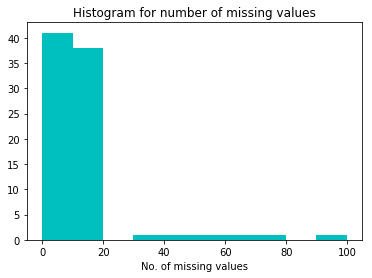

In [56]:
# Investigate patterns in the amount of missing data in each column.

plt.hist(df.percentage,facecolor='C');
plt.xlabel('No. of missing values')
plt.title('Histogram for number of missing values')


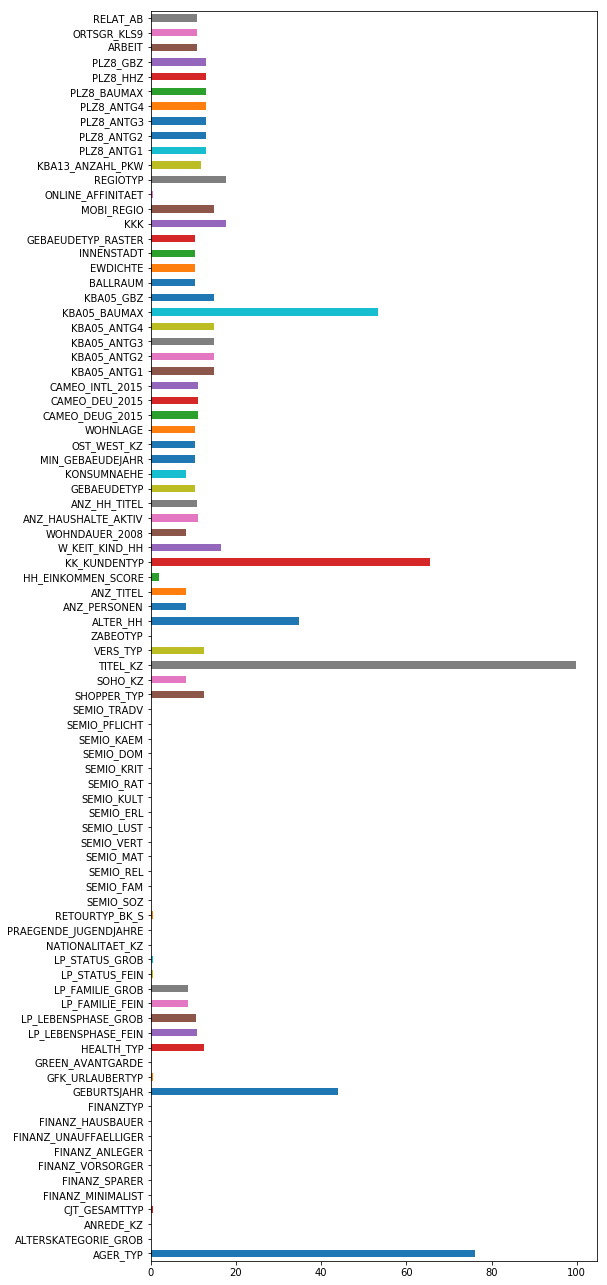

In [57]:
df.percentage.plot(kind='barh', figsize = (8,23))

In [58]:
df.percentage.median()

10.451728583594866

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f058c14acc0>]], dtype=object)

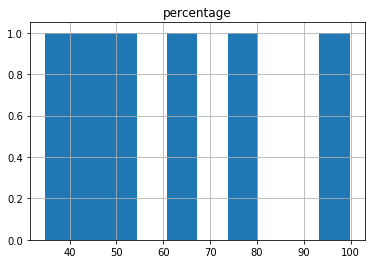

In [59]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

outliers = df[df.percentage>30]

outliers.hist()

In [60]:
outliers.index

Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')

In [61]:
azdias.drop(columns=outliers.index,axis="columns",inplace=True)
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

50% of the columns have missing values less than 100,000. From the bar graph, it is clear that the columns with maximum missing values are AGER_TYPE, GEBURTSJAHR, TITEL_KZ, KK_KUNDEN_TYP, ALTER_HH, KBA05_BAUMAX. These are the outliers that needs to be removed.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [62]:
# How much data is missing in each row of the dataset?

missing_rows = azdias.isnull().sum(axis=1)
missing_rows

0         41
1          0
2          0
3          7
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11        45
12         6
13         8
14        45
15         8
16         6
17        45
18         3
19         0
20        10
21         0
22         0
23         8
24        45
25         5
26        19
27         0
28         0
29         2
          ..
891191     0
891192     0
891193     0
891194     0
891195     0
891196     0
891197     0
891198     0
891199     0
891200     0
891201     0
891202     0
891203    13
891204     0
891205     0
891206     0
891207     0
891208     3
891209     0
891210     0
891211     0
891212     0
891213     0
891214     0
891215     0
891216     3
891217     3
891218     5
891219     0
891220     0
Length: 891221, dtype: int64

In [63]:
missing_rows.describe()

count    891221.000000
mean          5.403760
std          12.719533
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          47.000000
dtype: float64

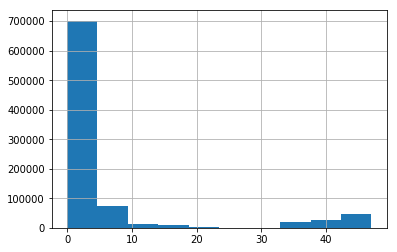

In [64]:
missing_rows.hist()

### Observation :
               As per the description, 50% of the rows have no missing values and 75% of the rows have less than or equal to 3 missing values. Also it can be clearly inferred from the histogram that the rows with higher missing values and lower missing values can be clearly separated into two groups.

In [65]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

threshold = 20

subset_less_than_thres = azdias[missing_rows < threshold]
subset_more_than_thres = azdias[missing_rows > threshold]

In [66]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def compare_distributions(column, subset_less_than_thres, subset_more_than_thres, threshold):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    fig.set_figwidth(10)
    ax1.set_title('Rows with missing values above {}'.format(threshold))
    sns.countplot(subset_more_than_thres.loc[:,column] , ax=ax1)
    ax2.set_title('Rows with missing values below {}'.format(threshold))    
    sns.countplot(subset_less_than_thres.loc[:,column] , ax=ax2)

In [67]:
zero_missing_columns = missing_columns[missing_columns==0]
zero_missing_columns

ALTERSKATEGORIE_GROB     0
ANREDE_KZ                0
FINANZ_MINIMALIST        0
FINANZ_SPARER            0
FINANZ_VORSORGER         0
FINANZ_ANLEGER           0
FINANZ_UNAUFFAELLIGER    0
FINANZ_HAUSBAUER         0
FINANZTYP                0
GREEN_AVANTGARDE         0
NATIONALITAET_KZ         0
PRAEGENDE_JUGENDJAHRE    0
SEMIO_SOZ                0
SEMIO_FAM                0
SEMIO_REL                0
SEMIO_MAT                0
SEMIO_VERT               0
SEMIO_LUST               0
SEMIO_ERL                0
SEMIO_KULT               0
SEMIO_RAT                0
SEMIO_KRIT               0
SEMIO_DOM                0
SEMIO_KAEM               0
SEMIO_PFLICHT            0
SEMIO_TRADV              0
ZABEOTYP                 0
dtype: int64

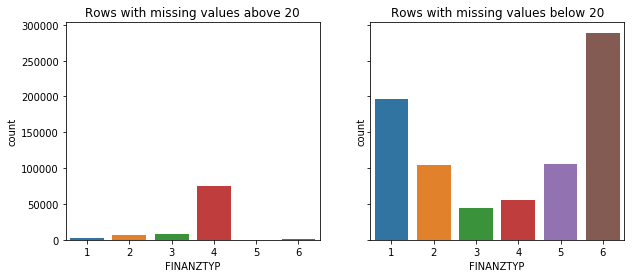

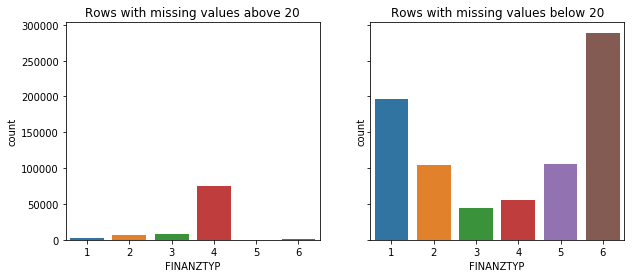

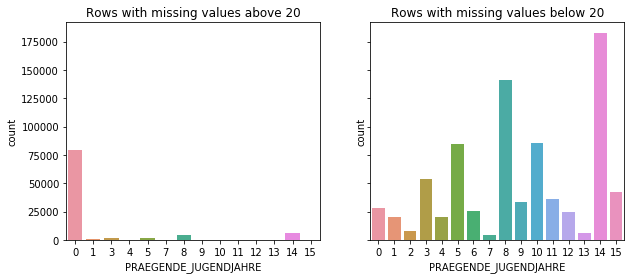

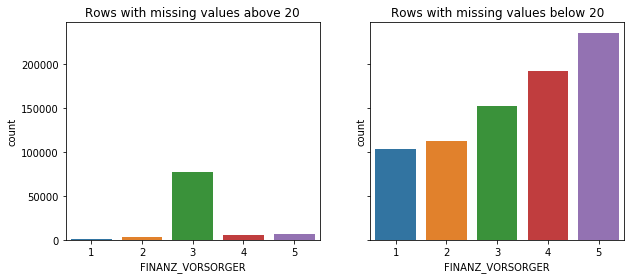

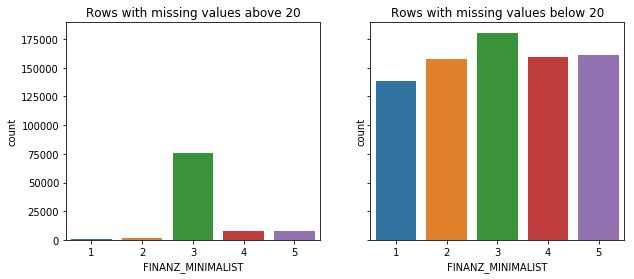

In [68]:
columns = np.random.choice(zero_missing_columns.index, 5).tolist()

for value in columns[:5]:
    compare_distributions(value,subset_less_than_thres, subset_more_than_thres, threshold)

#### Discussion 1.1.3: Assess Missing Data in Each Row

The distribution of data with missing values less than 20 is very different from the distribution with more missing values. Hence, we'll be using the subset with missing row values less than 20 for further analysis.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [69]:
# How many features are there of each data type?

processed_features = feature_summ[feature_summ.attribute.isin(subset_less_than_thres.columns.values)]
processed_features['type'].value_counts()

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [70]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical_features = processed_features[processed_features.type == 'categorical']
categorical_features


,attribute,information_level,type,missing_or_unknown
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]
21,NATIONALITAET_KZ,person,categorical,"[-1,0]"


In [71]:
# Re-encode categorical variable(s) to be kept in the analysis.

def classify_categorical_data(categorical_features, df):
    binary = []
    multi_level = []
    for variable in categorical_features.attribute.values:
        if df[variable].nunique() == 2:
            binary.append(variable)
        elif df[variable].nunique() > 2:
            multi_level.append(variable)  
    return binary, multi_level


In [72]:

binary, multi_level = classify_categorical_data(categorical_features,subset_less_than_thres)

for att in binary:
    print(subset_less_than_thres[att].value_counts())

2    415737
1    381577
Name: ANREDE_KZ, dtype: int64
0    622167
1    175147
Name: GREEN_AVANTGARDE, dtype: int64
0.0    790602
1.0      6712
Name: SOHO_KZ, dtype: int64
2.0    394118
1.0    366729
Name: VERS_TYP, dtype: int64
W    628889
O    168425
Name: OST_WEST_KZ, dtype: int64


In [73]:
subset_less_than_thres[multi_level].nunique()

CJT_GESAMTTYP        6
FINANZTYP            6
GFK_URLAUBERTYP     12
LP_FAMILIE_FEIN     11
LP_FAMILIE_GROB      5
LP_STATUS_FEIN      10
LP_STATUS_GROB       5
NATIONALITAET_KZ     4
SHOPPER_TYP          4
ZABEOTYP             6
GEBAEUDETYP          7
CAMEO_DEUG_2015      9
CAMEO_DEU_2015      44
dtype: int64

In [74]:
subset_less_than_thres.drop('CAMEO_DEU_2015',axis = 1,inplace=True)
subset_less_than_thres.drop('GEBAEUDETYP', axis = 1, inplace = True)
multi_level.remove('CAMEO_DEU_2015')
multi_level.remove('GEBAEUDETYP')

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [75]:
#Converting the OST_WEST_KZ column to int values

subset_less_than_thres['OST_WEST_KZ'].replace({'W':0,'O':1}, inplace=True)


/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [78]:
#One hot encoding of multi_level categories

encoded_data = pd.get_dummies(subset_less_than_thres, columns=multi_level)


In [79]:
encoded_data.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,ZABEOTYP_6,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9
1,1,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,0,0,0,0,1,0
2,3,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,1,0,0,0,0,0
3,4,2,4,2,5,2,1,2,0,2.0,...,0,0,1,0,0,0,0,0,0,0
4,3,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,1,0,0,0
5,1,2,3,1,5,2,2,5,0,3.0,...,0,0,0,0,0,0,0,0,1,0


#### Discussion 1.2.1: Re-Encode Categorical Features

From the above results, there are 4 binary, 1 non-binary and 13 categorical multi-level columns. Of this, the non-binary column OST_WEST_KZ has been converted to a binary column. CAMEO_DEU_2015 has a maximum number of variables with 44. This is too granular for any single category. Hence, we're dropping CAMEO_DEU_2015 column.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [80]:
mixed_features = processed_features[processed_features.type == 'mixed']
mixed_features

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [81]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
encoded_data['PRAEGENDE_JUGENDJAHRE'].head()

1    14
2    15
3     8
4     8
5     3
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [82]:
decade_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
mainstream = [1, 3, 5, 8, 10, 12, 14]

In [83]:
encoded_data['DECADE'] = encoded_data['PRAEGENDE_JUGENDJAHRE']

encoded_data['DECADE'].replace(decade_dict, inplace = True)

In [84]:
encoded_data['MOVEMENT'] = encoded_data['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 0 if x in mainstream else 1 )

encoded_data.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

In [85]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

encoded_data['CAMEO_INTL_2015'].head()

1    51
2    24
3    12
4    43
5    54
Name: CAMEO_INTL_2015, dtype: object

In [86]:
def generate_wealth(x):
    if pd.isnull(x):
        return np.nan
    else:
        return int(str(x)[1])
    
def generate_life_stage(x):
    if pd.isnull(x):
        return np.nan
    else:
        return int(str(x)[0])

In [87]:
encoded_data['WEALTH'] = encoded_data['CAMEO_INTL_2015'].apply(generate_wealth)

encoded_data['LIFE_STAGE'] = encoded_data['CAMEO_INTL_2015'].apply(generate_life_stage)

In [88]:
encoded_data.drop('CAMEO_INTL_2015', axis=1, inplace=True)
encoded_data.drop('LP_LEBENSPHASE_FEIN', axis=1, inplace=True)
encoded_data.drop('LP_LEBENSPHASE_GROB', axis=1, inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

PRAEGENDE_JUGENDJAHRE column has been split into two columns : Decade and Movement. The decade values are split between 1-6  corresponding to the decade ranges. If the movement is mainstream, it is assigned as 0 and if it is avantgarde it is 1.

CAMEO_INTL_2015 column has been split into two columns : Wealth and Life-Stage. As per the instructions, the tens place is assigned as the wealth value and the ones place is assigned to Life-Stage.

Columns LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB can be removed. LP_LEBENSPHASE_GROB provides details about life stage and rough salary scale. LP_LEBENSPHASE_FEIN provides details about life stage and fine scale. There are other ordinal columns which provide these details. Hence, we're removing these.

We will keep WOHNLAGE and PLZ8_BAUMAX columns as they provide unique details.

We're dropping the column GEBAEUDETYP as there is a discrepancy between testing and training data during one-hot encoding.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [89]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

encoded_data.columns.values

array(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM',
       'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL',
       'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM',
       'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SOHO_KZ', 'VERS_TYP',
       'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH',
       'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL',
       'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE',
       'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4',
       'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT',
       'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET',
       'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2',
       'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PL

In [90]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

encoded_data.shape

(797314, 144)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [91]:
def clean_data(feature_values, cust_demo):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    cust_demo = convert_to_nans(feature_values,cust_demo)
    
    # remove selected columns and rows,
    
    # Drop the columns with the maximum number of unknowns
    azdias_df = cust_demo.drop(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP','KBA05_BAUMAX', 'GEBAEUDETYP'],axis=1)
        
    # Select the subset of rows with the number of unknowns less than 20
    missing_rows = azdias_df.isnull().sum(axis=1)
    threshold = 20

    subset_below_thres = azdias_df[missing_rows < threshold]
    
    # Select the Non-Binary Categorical data and convert to float    
    processed_features = feature_values[feature_values.attribute.isin(subset_below_thres.columns.values)]    
    categorical_features = processed_features[processed_features.type == 'categorical']
    
    binary, multi_level = classify_categorical_data(categorical_features,subset_below_thres)
    
    subset_below_thres['OST_WEST_KZ'].replace({'W':0,'O':1}, inplace=True)
    
    # Drop the column with maximum number of categorical variables
    unique_df = subset_below_thres[multi_level].nunique()
    max_category_cols = ['']
    subset_below_thres.drop(['CAMEO_DEU_2015'],axis = 1,inplace=True)
    multi_level.remove('CAMEO_DEU_2015')
    
    # Encode other multi categorical columns using One Hot Encoding
    encoded_cat_data = pd.get_dummies(subset_below_thres, columns=multi_level)
    
    #Select the mixed columns and split them to two different columns
    mixed_features = processed_features[processed_features.type == 'mixed']
    
    encoded_cat_data['DECADE'] = encoded_cat_data['PRAEGENDE_JUGENDJAHRE']
    encoded_cat_data['DECADE'].replace(decade_dict, inplace=True)
    encoded_cat_data['MOVEMENT'] = encoded_cat_data['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 0 if x in mainstream else 1 )
    encoded_cat_data.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
    
    encoded_cat_data['WEALTH'] = encoded_cat_data['CAMEO_INTL_2015'].apply(generate_wealth)
    encoded_cat_data['LIFE_STAGE'] = encoded_cat_data['CAMEO_INTL_2015'].apply(generate_life_stage)
    encoded_cat_data.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
    # Drop unwanted mixed columns
    encoded_cat_data.drop('LP_LEBENSPHASE_FEIN', axis=1, inplace=True)
    encoded_cat_data.drop('LP_LEBENSPHASE_GROB', axis=1, inplace=True)
    
    # Return the cleaned dataframe.
    
    return encoded_cat_data

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [92]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

encoded_data.isnull().sum().sum()


713037

In [93]:
imputer = Imputer(strategy='most_frequent')
imputed_data = pd.DataFrame(imputer.fit_transform(encoded_data), columns = encoded_data.columns)


In [94]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(imputed_data), columns = imputed_data.columns)


In [95]:
scaled_data.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,-1.681507,0.958036,-1.494473,1.538075,-1.040722,1.466297,0.959684,1.338719,-0.530576,1.010230,...,-0.386946,-0.272816,-0.391224,-0.329068,2.22084,-0.396135,1.110442,-0.585705,-1.249190,1.175743
1,0.169339,0.958036,-1.494473,0.864718,-1.766964,-0.570881,0.244989,1.338719,1.884743,1.010230,...,2.584340,-0.272816,-0.391224,-0.329068,-0.45028,-0.396135,1.110442,1.707344,0.766825,-0.869671
2,1.094762,0.958036,0.683246,-0.481994,1.138005,-0.570881,-1.184403,-0.792225,-0.530576,-0.311804,...,-0.386946,-0.272816,-0.391224,-0.329068,-0.45028,-0.396135,-0.107865,-0.585705,-0.577185,-1.551476
3,0.169339,-1.043802,0.683246,0.191362,0.411763,-1.249940,0.244989,-0.792225,-0.530576,1.010230,...,-0.386946,-0.272816,2.556082,-0.329068,-0.45028,-0.396135,-0.107865,-0.585705,0.094820,0.493938
4,-1.681507,0.958036,-0.042660,-1.155350,1.138005,-0.570881,-0.469707,1.338719,-0.530576,1.010230,...,-0.386946,-0.272816,-0.391224,-0.329068,2.22084,-0.396135,-1.326171,-0.585705,0.766825,1.175743


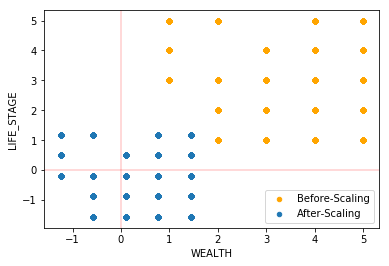

In [96]:
ax=imputed_data.plot.scatter(x="WEALTH",y="LIFE_STAGE",label="Before-Scaling",color="orange")
scaled_data.plot.scatter(x="WEALTH",y="LIFE_STAGE",label="After-Scaling",ax=ax)
plt.axhline(0, color='red',alpha=0.2)
plt.axvline(0, color='red',alpha=0.2);
plt.show()

### Discussion 2.1: Apply Feature Scaling

I have removed the NaNs using the most frequent value. I have applied feature scaling using Standard Scaler.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [97]:
# Apply PCA to the data.
pca = PCA(n_components = 100)
pca.fit_transform(scaled_data)

array([[ 4.38654502, -3.88286515, -3.27271011, ...,  0.28831793,
        -0.22587571, -0.20328858],
       [-0.1272407 , -0.40285193, -3.19306979, ..., -0.3795688 ,
        -0.33361452, -0.41352359],
       [-4.62967068,  1.75925889, -1.27987497, ...,  1.00943131,
        -0.73739322, -0.27302982],
       ..., 
       [-1.05830283, -3.89205612, -3.39857702, ..., -0.01880155,
         0.06390289,  0.47563899],
       [ 6.19305865, -4.40238629,  2.76718305, ..., -0.66013237,
        -0.25043883, -0.17651234],
       [ 0.37871249,  2.37129513,  2.09639084, ...,  0.24827745,
        -0.07031054,  0.20152474]])

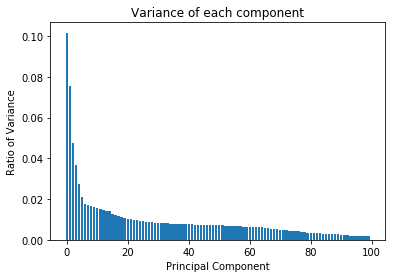

In [98]:
# Investigate the variance accounted for by each principal component.

plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.title("Variance of each component")
plt.xlabel("Principal Component")
plt.ylabel("Ratio of Variance")
plt.show()

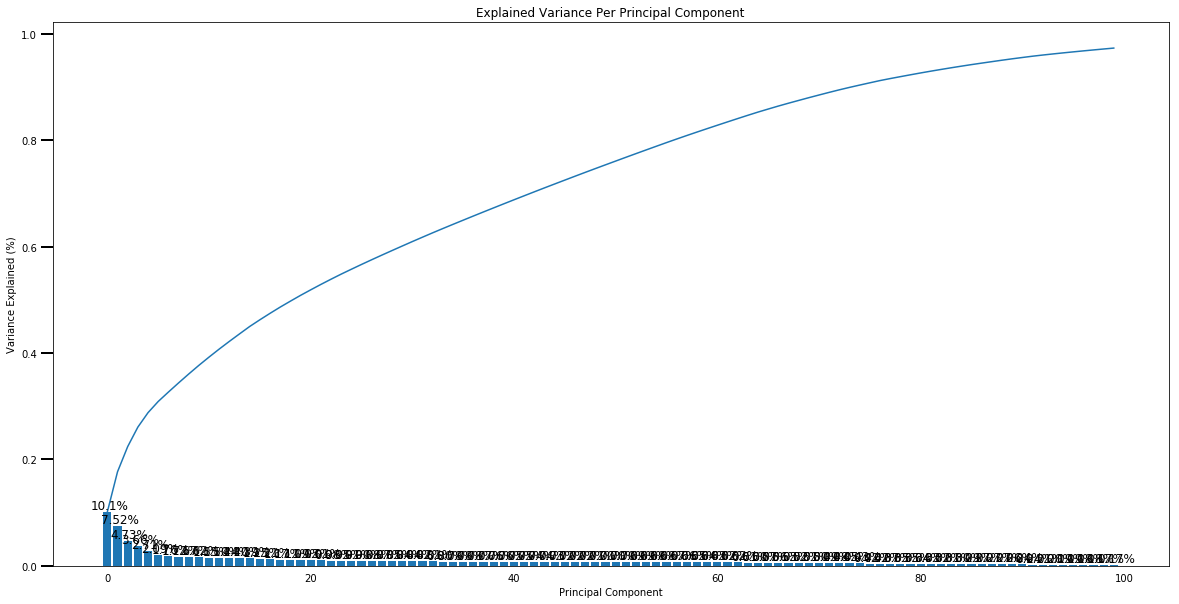

In [99]:
#Function provided during the course: 

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(20, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    

scree_plot(pca)

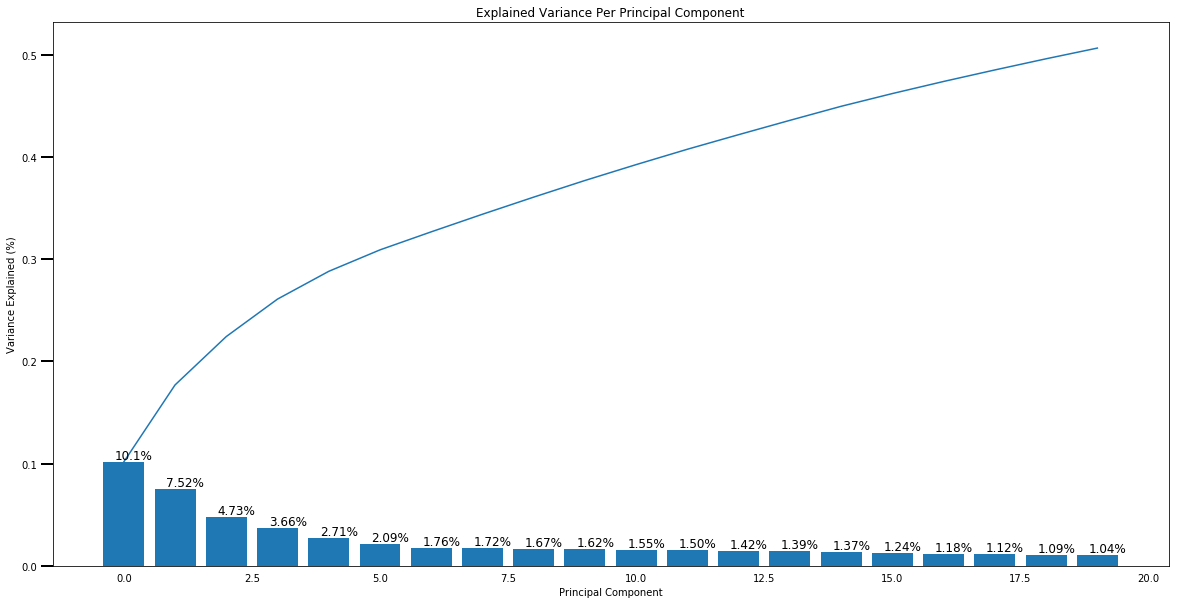

In [100]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca = PCA(n_components = 20)
gen_pca = pca.fit_transform(scaled_data)

scree_plot(pca)

### Discussion 2.2: Perform Dimensionality Reduction

As we can see from the scree polt, after the first 20 components, the variance explained by each component reduces to less than 1%. Hence we are retaining the first 20 components as they explain almost 50% of the variance.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [101]:
def map_weights(data,pca,i):
    df = pd.DataFrame(pca.components_,columns= data.columns).iloc[i]
    weights = df.sort_values(ascending=False)
    return weights

In [102]:
def compare_components(weights,i):
    weights.plot(kind='bar', title = 'Weight Comparison - Component ' + str(i))
    ax = plt.gca()
    ax.grid(alpha = 1)
    ax.set_axisbelow(True)
    plt.show()

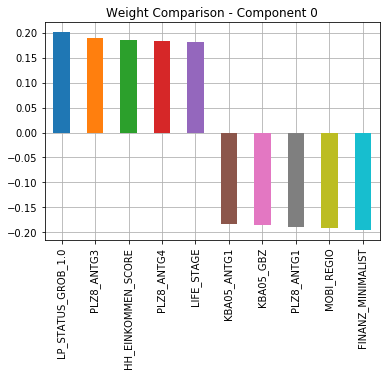

In [103]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

pca_weight_0 = map_weights(scaled_data,pca, 0)

compare_components(pd.concat([pca_weight_0.head(5),pca_weight_0.tail(5)]), 0)

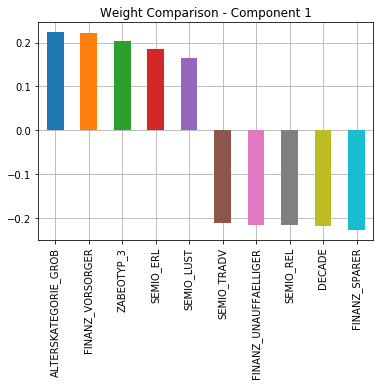

In [104]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.


pca_weight_1 = map_weights(scaled_data,pca, 1)

compare_components(pd.concat([pca_weight_1.head(5),pca_weight_1.tail(5)]), 1)

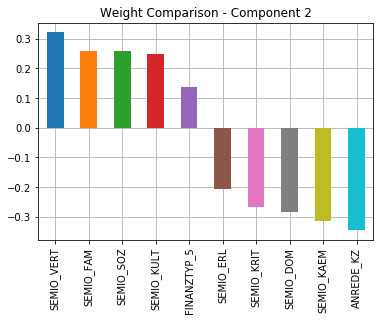

In [105]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_weight_2 = map_weights(scaled_data,pca, 2)

compare_components(pd.concat([pca_weight_2.head(5),pca_weight_2.tail(5)]), 2)


### Discussion 2.3: Interpret Principal Components

Principal Component 1:
      
  Positive Feaures:
              - LP_STATUS_GROB_1.0 - Social status
              - PLZ8_ANTG3 - Number of 6-10 family houses in the PLZ8 region
              - HH_EINKOMMEN_SCORE - Estimated household net income
              - PLZ8_ANTG4 - Number of 10+ family houses in the PLZ8 region
              - Life Stage
              
  Negative Features:
              - KBA05_ANTG1 - Number of 1-2 family houses in the microcell
              - KBA05_GBZ - Number of buildings in the microcell
              - PLZ8_ANTG1 - Number of 1-2 family houses in the PLZ8 region
              - MOBI_REGIO - Movement patterns
              - FINANZ_MINIMALIST - Financial Typology - Low Financial Interest
              
  The first component has explains the relationship between income, social status and wealth. In the above features, PLZ8_ANTG3 and PLZ8_ANTG4 have a positive correlation. The number of 10+ family homes and the share of 6-10 family homes increase together. Meanwhile, PLZ8_ANTG1 and PLZ8_ANTG3 have a negative correlation. In this component, the buildings in   micro cell and low financial interest are considered as negative features. Interestingly, LP_STATUS_GROB and FINANZ_MINIMALIST have a negative correlation. 
      
Principal Component 2:
      
  Positive Feaures:
              - ALTERSKATEGORIE_GROB - Estimated age based on given name analysis
              - FINANZ_VORSORGER - Financial Typology - Be Prepared
              - ZABEOTYP_3 - Energy Consumption Typology - Fair Supplied
              - SEMIO_ERL - Personality Typology - Event-oriented
              - SEMIO_LUST - Personality Typology - Sensual-minded
              
  Negative Features:
              - SEMIO_TRADV - Personality Typology - Traditional-minded
              - FINANZ_UNAUFFAELLIGER - Financial Typology - Inconspicuous
              - SEMIO_REL - Personality Typology - Religious
              - Decade
              - FINANZ_SPARER - Financial Typology - Money-saver
              
  The second component explains the relationship between personality, age and attitude towards investment. In the above features, SEMIO_TRADV and FINANZ_UNAUFFAELLIGER have a positive correlation. This shows a relation that traditional-minded people don't tend to pay much attention towards finances. Also, there exists a positive relation between SEMIO_REL and FINANZ_UNAUFFAELLIGER. This shows that, traditional minded religious people prefer saving money than towards investing.
      
Principal Component 3:
      
  Positive Feaures:
              - SEMIO_VERT - Personality Typology - Dreamful
              - SEMIO_FAM - Personality Typology - Family-minded
              - SEMIO_SOZ  - Personality Typology - Socially-minded
              - SEMIO_KULT - Personality Typology - Cultural-minded
              - FINANZTYP_5 - Financial Typology - Investor
  Negative Features:
              - SEMIO_ERL - Personality Typology - Event-oriented
              - SEMIO_KRIT - Personality Typology - Critical-minded
              - SEMIO_DOM - Personality Typology - Dominant-minded
              - SEMIO_KAEM - Personality Typology - Combative attitude
              - ANREDE_KZ - Gender
              
  The third component explains the relationship gender, personality traits and investments. In the above features, SEMIO_VERT and SEMIO_KAEM have a negative correlation suggesting that people with a combative attitude aren't dreamful. SEMIO_FAM, SEMIO_SOZ and SEMIO_KULT have a positive correlation. This shows that people with families are highly social and culture oriented. SEMIO_DOM and SEMIO_FAM have a negative correlation suggesting that people with families are not dominant-minded.             
    

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [106]:
scores = []

for i in range(2,20,2):
    
    kmeans = KMeans(n_clusters = i)
    fit = kmeans.fit(gen_pca)
    score = np.abs(kmeans.score(gen_pca))
    print("For n_clusters={}, average within-cluster distances = {}".format(i,score))
    scores.append(score)
    
    

For n_clusters=2, average within-cluster distances = 49201915.64514555
For n_clusters=4, average within-cluster distances = 42077689.44251778
For n_clusters=6, average within-cluster distances = 38314002.412103586
For n_clusters=8, average within-cluster distances = 35900653.33285198
For n_clusters=10, average within-cluster distances = 33961286.15360036
For n_clusters=12, average within-cluster distances = 32204916.976749472
For n_clusters=14, average within-cluster distances = 30941225.33991446
For n_clusters=16, average within-cluster distances = 29605833.00293522
For n_clusters=18, average within-cluster distances = 28908704.186946265


Text(0.5,1,'Score vs. Number of clusters')

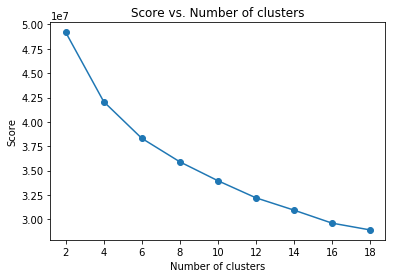

In [109]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(range(2,20,2), scores, linestyle='-', marker='o')

plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.title('Score vs. Number of clusters')

In [108]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

gen_kmeans = KMeans(n_clusters = 16) 

gen_model = gen_kmeans.fit(gen_pca) 

predictions = gen_model.predict(gen_pca)

In [110]:
gen_pop = pd.DataFrame(predictions)
gen_pop.count()

0    797314
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0578c2cda0>]], dtype=object)

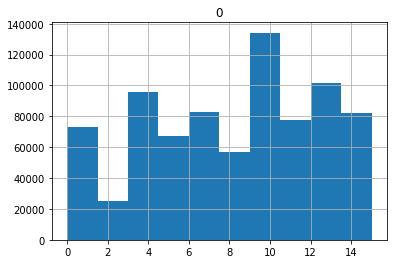

In [111]:
gen_pop.hist()

### Discussion 3.1: Apply Clustering to General Population

From the line plot it is visible that, the score of the KMeans model undergoes little change after 16 clusters. Since there is no visible elbow in the score and the change is gradual, we'll be segmenting the population into 16 clusters.


### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [112]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',delimiter=';')
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [113]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

demo_data = clean_data(feature_summ, customers)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [114]:
demo_imputed_data = pd.DataFrame(imputer.transform(demo_data), columns = demo_data.columns)

demo_scaled_data = pd.DataFrame(scaler.transform(demo_imputed_data), columns = demo_imputed_data.columns)

demo_scaled_data.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,1.094762,-1.043802,1.409152,-1.15535,1.138005,-1.249940,-0.469707,-0.792225,1.884743,-1.633838,...,-0.386946,-0.272816,-0.391224,-0.329068,-0.45028,-0.396135,-1.326171,1.707344,0.094820,-1.551476
1,1.094762,0.958036,1.409152,-1.15535,1.138005,-1.249940,0.959684,0.628404,1.884743,-0.311804,...,-0.386946,3.665478,-0.391224,-0.329068,-0.45028,-0.396135,-1.326171,1.707344,0.766825,-0.187866
2,1.094762,-1.043802,1.409152,-1.15535,1.138005,-0.570881,-1.184403,-0.792225,-0.530576,-0.311804,...,2.584340,-0.272816,-0.391224,-0.329068,-0.45028,-0.396135,-1.935324,-0.585705,0.766825,-0.869671
3,0.169339,-1.043802,-0.042660,-1.15535,0.411763,0.787237,1.674380,-0.792225,-0.530576,1.010230,...,-0.386946,-0.272816,-0.391224,3.038887,-0.45028,-0.396135,-0.107865,-0.585705,-1.249190,0.493938
4,0.169339,-1.043802,1.409152,-1.15535,1.138005,-1.249940,-0.469707,-0.081911,1.884743,1.010230,...,-0.386946,3.665478,-0.391224,-0.329068,-0.45028,-0.396135,-1.326171,1.707344,0.766825,-0.187866


In [115]:
demo_pca = pca.transform(demo_scaled_data)

In [116]:
demo_data_predictions = gen_model.predict(demo_pca)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0578da91d0>]], dtype=object)

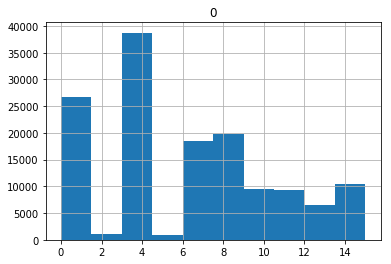

In [117]:
cust_pop = pd.DataFrame(demo_data_predictions)
cust_pop.hist()

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Text(0.5,1,'General Clusters')

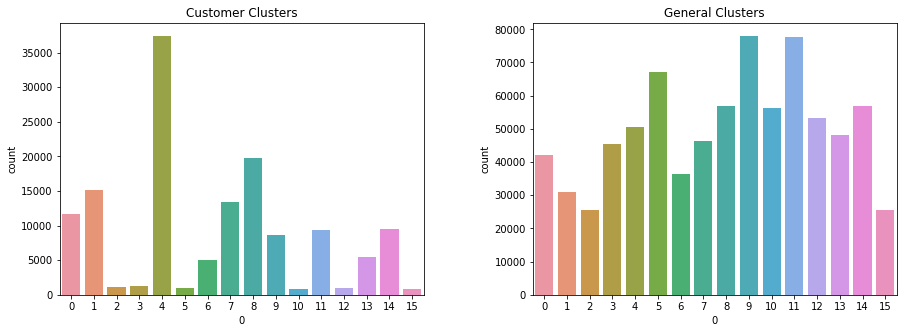

In [118]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

figure, axs = plt.subplots(nrows=1, ncols=2, figsize = (15,5))
figure.subplots_adjust(hspace = 1, wspace=.3)

sns.countplot(cust_pop[0], ax=axs[0])
axs[0].set_title('Customer Clusters')
sns.countplot(gen_pop[0], ax=axs[1])
axs[1].set_title('General Clusters')

In [119]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

gen_4 = scaler.inverse_transform(pca.inverse_transform(gen_model.cluster_centers_[4]))
gen_cluster_4 = pd.Series(data = gen_4, index = imputed_data.columns)

cust_4 = scaler.inverse_transform(pca.inverse_transform(gen_model.cluster_centers_[4]))
overrepresented_cluster = pd.Series(data = cust_4, index = demo_scaled_data.columns)

overrepresented_cluster.sort_values()

LP_STATUS_FEIN_4.0       -0.041620
FINANZTYP_1              -0.040193
ANZ_HH_TITEL             -0.033005
LP_STATUS_FEIN_2.0       -0.024338
ANZ_TITEL                -0.006604
KBA05_ANTG4              -0.006549
LP_STATUS_FEIN_7.0       -0.003167
LP_FAMILIE_FEIN_6.0      -0.002775
NATIONALITAET_KZ_3       -0.002042
LP_STATUS_GROB_2.0       -0.000576
LP_FAMILIE_FEIN_3.0      -0.000481
LP_STATUS_FEIN_8.0       -0.000206
LP_FAMILIE_FEIN_4.0       0.003866
LP_STATUS_GROB_4.0        0.005664
LP_STATUS_FEIN_9.0        0.005870
LP_STATUS_GROB_3.0        0.006841
LP_FAMILIE_FEIN_7.0       0.007341
SOHO_KZ                   0.008169
NATIONALITAET_KZ_0        0.008499
LP_STATUS_FEIN_6.0        0.010008
ZABEOTYP_5                0.012020
LP_FAMILIE_FEIN_5.0       0.012927
LP_FAMILIE_FEIN_9.0       0.015613
LP_FAMILIE_GROB_3.0       0.016313
LP_STATUS_FEIN_5.0        0.017531
ZABEOTYP_4                0.021846
LP_STATUS_FEIN_3.0        0.023513
GFK_URLAUBERTYP_9.0       0.027996
CAMEO_DEUG_2015_8   

In [120]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

gen_11 = scaler.inverse_transform(pca.inverse_transform(gen_model.cluster_centers_[11]))
gen_cluster_11 = pd.Series(data = gen_11, index = imputed_data.columns)

cluster_11 = scaler.inverse_transform(pca.inverse_transform(gen_model.cluster_centers_[11]))
underrepresented_cluster = pd.Series(data = cluster_11, index = demo_scaled_data.columns)

underrepresented_cluster.sort_values()

ZABEOTYP_1                -0.119633
FINANZTYP_4               -0.049128
LP_STATUS_FEIN_5.0        -0.047069
FINANZTYP_3               -0.041934
SHOPPER_TYP_0.0           -0.010509
CAMEO_DEUG_2015_2         -0.000710
LP_FAMILIE_FEIN_8.0       -0.000378
ANZ_TITEL                 -0.000346
LP_FAMILIE_FEIN_3.0        0.000248
LP_FAMILIE_FEIN_5.0        0.001121
LP_FAMILIE_FEIN_6.0        0.001389
LP_STATUS_FEIN_8.0         0.001901
LP_FAMILIE_FEIN_7.0        0.002128
LP_FAMILIE_FEIN_4.0        0.002146
NATIONALITAET_KZ_0         0.002431
LP_STATUS_FEIN_7.0         0.002821
LP_FAMILIE_GROB_4.0        0.003139
LP_FAMILIE_GROB_3.0        0.003515
GFK_URLAUBERTYP_9.0        0.004694
ZABEOTYP_2                 0.005793
SOHO_KZ                    0.008662
LP_FAMILIE_FEIN_9.0        0.010140
NATIONALITAET_KZ_3         0.011013
GREEN_AVANTGARDE           0.013693
CAMEO_DEUG_2015_1          0.013725
LP_STATUS_FEIN_6.0         0.014311
LP_STATUS_GROB_3.0         0.017132
GFK_URLAUBERTYP_2.0        0

In [121]:
#Comparing the primary columns in the pca components.

positive_cols = ["LP_STATUS_GROB_1.0", "PLZ8_ANTG3", "HH_EINKOMMEN_SCORE", "PLZ8_ANTG4", "LIFE_STAGE","ALTERSKATEGORIE_GROB","FINANZ_VORSORGER"
                ,"ZABEOTYP_3", "SEMIO_ERL", "SEMIO_LUST", "SEMIO_VERT", "SEMIO_FAM", "SEMIO_SOZ", "SEMIO_KULT", "FINANZTYP_5"]

negative_cols = ["KBA05_ANTG1","KBA05_GBZ","PLZ8_ANTG1","MOBI_REGIO","FINANZ_MINIMALIST","SEMIO_TRADV","FINANZ_UNAUFFAELLIGER",
                "SEMIO_REL", "DECADE", "FINANZ_SPARER", "SEMIO_ERL", "SEMIO_KRIT", "SEMIO_DOM","SEMIO_KAEM","ANREDE_KZ"]


In [122]:
overrep_df =pd.DataFrame({"features": demo_imputed_data.columns, "cust_4": overrepresented_cluster ,"gen_4": underrepresented_cluster})

overrep_df[overrep_df["features"].isin(positive_cols)]

,features,cust_4,gen_4
ALTERSKATEGORIE_GROB,ALTERSKATEGORIE_GROB,3.174715,3.645532
FINANZ_VORSORGER,FINANZ_VORSORGER,4.041215,4.296807
SEMIO_SOZ,SEMIO_SOZ,5.428758,2.922704
SEMIO_FAM,SEMIO_FAM,4.984438,2.221878
SEMIO_VERT,SEMIO_VERT,6.259278,2.839670
SEMIO_LUST,SEMIO_LUST,5.065968,5.268964
SEMIO_ERL,SEMIO_ERL,3.925800,6.548880
SEMIO_KULT,SEMIO_KULT,5.051150,1.966903
HH_EINKOMMEN_SCORE,HH_EINKOMMEN_SCORE,2.277167,5.583055
PLZ8_ANTG3,PLZ8_ANTG3,1.139691,2.315347


In [123]:
overrep_df[overrep_df["features"].isin(negative_cols)]

,features,cust_4,gen_4
ANREDE_KZ,ANREDE_KZ,1.053534,1.933328
FINANZ_MINIMALIST,FINANZ_MINIMALIST,4.760220,2.486665
FINANZ_SPARER,FINANZ_SPARER,1.848558,1.885608
FINANZ_UNAUFFAELLIGER,FINANZ_UNAUFFAELLIGER,2.328368,1.631882
SEMIO_REL,SEMIO_REL,3.977810,1.929834
SEMIO_ERL,SEMIO_ERL,3.925800,6.548880
SEMIO_KRIT,SEMIO_KRIT,3.034827,5.969270
SEMIO_DOM,SEMIO_DOM,3.272030,5.878368
SEMIO_KAEM,SEMIO_KAEM,2.601741,6.084208
SEMIO_TRADV,SEMIO_TRADV,3.298324,2.362251


In [125]:
underrep_df =pd.DataFrame({"features": demo_imputed_data.columns, "cust_11": underrepresented_cluster ,"gen_11": gen_cluster_11})

underrep_df[underrep_df["features"].isin(positive_cols)]

,features,cust_11,gen_11
ALTERSKATEGORIE_GROB,ALTERSKATEGORIE_GROB,3.645532,3.645532
FINANZ_VORSORGER,FINANZ_VORSORGER,4.296807,4.296807
SEMIO_SOZ,SEMIO_SOZ,2.922704,2.922704
SEMIO_FAM,SEMIO_FAM,2.221878,2.221878
SEMIO_VERT,SEMIO_VERT,2.839670,2.839670
SEMIO_LUST,SEMIO_LUST,5.268964,5.268964
SEMIO_ERL,SEMIO_ERL,6.548880,6.548880
SEMIO_KULT,SEMIO_KULT,1.966903,1.966903
HH_EINKOMMEN_SCORE,HH_EINKOMMEN_SCORE,5.583055,5.583055
PLZ8_ANTG3,PLZ8_ANTG3,2.315347,2.315347


In [126]:
underrep_df[underrep_df["features"].isin(negative_cols)]

,features,cust_11,gen_11
ANREDE_KZ,ANREDE_KZ,1.933328,1.933328
FINANZ_MINIMALIST,FINANZ_MINIMALIST,2.486665,2.486665
FINANZ_SPARER,FINANZ_SPARER,1.885608,1.885608
FINANZ_UNAUFFAELLIGER,FINANZ_UNAUFFAELLIGER,1.631882,1.631882
SEMIO_REL,SEMIO_REL,1.929834,1.929834
SEMIO_ERL,SEMIO_ERL,6.548880,6.548880
SEMIO_KRIT,SEMIO_KRIT,5.969270,5.969270
SEMIO_DOM,SEMIO_DOM,5.878368,5.878368
SEMIO_KAEM,SEMIO_KAEM,6.084208,6.084208
SEMIO_TRADV,SEMIO_TRADV,2.362251,2.362251


### Discussion 3.3: Compare Customer Data to Demographics Data

Cluster 4 is overrepresented in the customer data compared to general data.

From the correlations between the columns, the following things are clear :
    
   - The mail order company's customers majorly consist of people of the age 46-60 (ALTERSKATEGORIE_GROB = 3.174715).
   - The customers have a very high affinity towards investing (FINANZ_ANLEGER=0.266453)
   - They tend to be more event-oriented and are less social-minded and family-minded(SEMIO_SOZ=5.428758, SEMIO_ERL=3.925800)
   - They include high income earners of middle age.(HH_EINKOMMEN_SCORE=2.277167)
   - The customers are majorly men (ANREDE_KZ=1.053534).


Cluster 11 is underrepresented in the customer data compared to general data.

From the correlations between the columns, the following people are underrepresented :

   - The people of age late 60s (ALTERSKATEGORIE_GROB=3.645532)
   - Females (ANREDE_KZ=1.933328)
   - People who are family-minded, who tend to be dreamful(SEMIO_FAM=2.221878)
   - People who are single, money-saving and low-income earners(FINANZ_SPARER=1.885608) 
   - People who are traditional-minded and religious (SEMIO_TRADV=1.929834)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.